In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [16]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))
    ])

transform = transforms.ToTensor()

mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
(x_train,y_train),(x_test,y_test)=tf.keras.datasets.mnist.load_data()
x_train.shape

data_loader = torch.utils.data.DataLoader(dataset=mnist_data,
                                          batch_size=64,
                                          shuffle=True)

11501568/11490434 [==============================] - 0s 0us/step


In [17]:
num_of_trainImgs = x_train.shape[0] #60000 here
num_of_testImgs = x_test.shape[0] #10000 here
img_width = 28
img_height = 28
 
x_train = x_train.reshape(x_train.shape[0], img_height, img_width, 1)
x_test = x_test.reshape(x_test.shape[0], img_height, img_width, 1)
input_shape = (img_height, img_width, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255


print("X_train Shape : ",x_train.shape)
print("Number of images in x_train ",x_train.shape[0])
print("Number of images in x_test ",x_test.shape[0])

X_train Shape :  (60000, 28, 28, 1)
Number of images in x_train  60000
Number of images in x_test  10000


In [3]:
dataiter = iter(data_loader)
images, labels = dataiter.next()
print(torch.min(images), torch.max(images))

tensor(0.) tensor(1.)


In [4]:
# repeatedly reduce the size
class Autoencoder_Linear(nn.Module):
    def __init__(self):
        super().__init__()        
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128), # (N, 784) -> (N, 128)
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 3) # -> N, 3
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
# Input [-1, +1] -> use nn.Tanh

In [5]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()        
        # N, 1, 28, 28
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1), # -> N, 16, 14, 14
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.Conv2d(32, 64, 7) # -> N, 64, 1, 1
        )
        
        # N , 64, 1, 1
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # N, 16, 14, 14 (N,16,13,13 without output_padding)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1), # N, 1, 28, 28  (N,1,27,27)
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
 
# Note: nn.MaxPool2d -> use nn.MaxUnpool2d, or use different kernelsize, stride etc to compensate...
# Input [-1, +1] -> use nn.Tanh

In [6]:
model = Autoencoder()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=1e-3, 
                             weight_decay=1e-5)

In [7]:
# Point to training loop video
num_epochs = 1
outputs = []
for epoch in range(num_epochs):
    for (img, _) in data_loader:
        # img = img.reshape(-1, 28*28) # -> use for Autoencoder_Linear
        recon = model(img)
        loss = criterion(recon, img)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    outputs.append((epoch, img, recon))

Epoch:1, Loss:0.0092


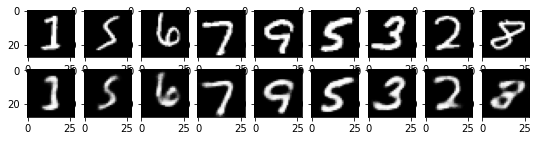

In [8]:
for k in range(0, num_epochs, 4):
    plt.figure(figsize=(9, 2))
    plt.gray()
    imgs = outputs[k][1].detach().numpy()
    recon = outputs[k][2].detach().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        # item = item.reshape(-1, 28,28) # -> use for Autoencoder_Linear
        # item: 1, 28, 28
        plt.imshow(item[0])
            
    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1) # row_length + i + 1
        # item = item.reshape(-1, 28,28) # -> use for Autoencoder_Linear
        # item: 1, 28, 28
        plt.imshow(item[0])

In [18]:
import tensorflow as tf
from tensorflow.python.ops.nn_ops import dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Conv2D,Flatten,MaxPooling2D

model=Sequential()
model.add(Conv2D(28, kernel_size=(3, 3),input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation=tf.nn.relu))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))

In [19]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [20]:
model.fit(x_train, y_train,
          batch_size=128,
          epochs=12,
          verbose=1,
          validation_data=(x_test, y_test))

Epoch 1/12
469/469 [==============================] - 25s 52ms/step - loss: 0.2709 - accuracy: 0.9204 - val_loss: 0.1018 - val_accuracy: 0.9691
Epoch 2/12
469/469 [==============================] - 24s 51ms/step - loss: 0.1082 - accuracy: 0.9677 - val_loss: 0.0718 - val_accuracy: 0.9774
Epoch 3/12
469/469 [==============================] - 24s 51ms/step - loss: 0.0767 - accuracy: 0.9765 - val_loss: 0.0595 - val_accuracy: 0.9814
Epoch 4/12
469/469 [==============================] - 24s 51ms/step - loss: 0.0559 - accuracy: 0.9831 - val_loss: 0.0568 - val_accuracy: 0.9819
Epoch 5/12
469/469 [==============================] - 24s 51ms/step - loss: 0.0444 - accuracy: 0.9862 - val_loss: 0.0515 - val_accuracy: 0.9840
Epoch 6/12
469/469 [==============================] - 24s 51ms/step - loss: 0.0365 - accuracy: 0.9882 - val_loss: 0.0500 - val_accuracy: 0.9838
Epoch 7/12
469/469 [==============================] - 24s 50ms/step - loss: 0.0306 - accuracy: 0.9908 - val_loss: 0.0557 - val_accuracy:

In [21]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.05288457125425339
Test accuracy: 0.9858999848365784


In [22]:
model.save('trained_model.h5')